In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import pickle
#from scipy.spatial import cKDTree
#from SCTransform import SCTransform

# if you installed the nico package 
import nico
from nico import Annotations as sann
    
# if you did not install the nico package and downloaded the nico files into the current directory
# import Annotations as sann


import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"



### Usage introduction 
Please download the sample data from the git repository nico_tutorial and keep all the files and folders in
the same directory to complete the tutorial. Unzip inputRef.zip and inputQuery.zip

inputRef  (single-cell RNA-sequencing data) 
inputQuery (single-cell resolution spatial transcriptomics data)
NiCoLRdb.txt (Ligand-receptor database file) 

The following notebook normalizes the count data and computes the initial Leiden clustering on the spatial transcriptomics 
data to perform the cell type annotation using NiCo:
Start_Data_prep.ipynb

Once all the steps of the data preparation notebook are finalized, run the core notebook to perform the full NiCo analysis: 
nico_analysis_highres_image_tech.ipynb


In [2]:
print(nico.__version__)

1.4.0


In [3]:
# This is input data path for the scRNA-seq and spatial data 
# If the data is not in h5ad or csv format then please adjust following the standard scanpy routine. 

scdatapath='./inputRef/'
spdatapath='./inputQuery/'

ad_spatial_ori=sc.read_h5ad(spdatapath+'spatial.h5ad')
ad_seq_ori=sc.read_h5ad(scdatapath+'single_cell.h5ad') 



In [4]:
%ls inputRef

Original_counts.h5ad  single_cell.h5ad


In [5]:
%ls inputQuery

spatial.h5ad


%Check count data information 

In [6]:
ad_spatial_ori.layers['counts'].todense()

matrix([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 3, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]])

In [7]:
ad_seq_ori.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# data size of the variables 
print(ad_spatial_ori)
print(ad_seq_ori)

AnnData object with n_obs × n_vars = 217218 × 343
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_cell_RNA', 'nFeature_cell_RNA', 'sample', 'patient', 'lineage', 'finest_CT1', 'fine_CT2', 'fine_CT3', 'fine_CT4', 'broad_CT5', 'broad_CT6', 'sample_name', 'disease_status', 'fibrosis', 'clinical_diagnosis'
    obsm: 'spatial'
    layers: 'counts'
AnnData object with n_obs × n_vars = 80749 × 44583
    obs: 'donor_id', 'study', 'disease', 'cell_type', 'cell_type_broad'
    var: 'gene_name', 'gene_id'


In [9]:
ad_spatial_ori.X=ad_spatial_ori.layers['counts']

In [10]:
# data size of the variables 
print(ad_spatial_ori)
print(ad_seq_ori)


AnnData object with n_obs × n_vars = 217218 × 343
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_cell_RNA', 'nFeature_cell_RNA', 'sample', 'patient', 'lineage', 'finest_CT1', 'fine_CT2', 'fine_CT3', 'fine_CT4', 'broad_CT5', 'broad_CT6', 'sample_name', 'disease_status', 'fibrosis', 'clinical_diagnosis'
    obsm: 'spatial'
    layers: 'counts'
AnnData object with n_obs × n_vars = 80749 × 44583
    obs: 'donor_id', 'study', 'disease', 'cell_type', 'cell_type_broad'
    var: 'gene_name', 'gene_id'


% convert ensembl id into gene symbol 

In [11]:
df=pd.read_csv('ensembl_id_to_gene_symbols.csv')
data=df.to_numpy()

ensembl2gene={}
for i in range(len(data)):
    l=data[i,0].split('.')
    ensembl2gene[l[0]]=data[i,1]

gname = ad_seq_ori.var_names 

In [12]:
my_gene_symbol=[]
for i in range(len(gname)):
    try: 
        id_found=ensembl2gene[gname[i]]
    except KeyError:
        id_found='NA'
    my_gene_symbol.append(id_found)

my_gene_symbol=np.array(my_gene_symbol)

In [13]:
ad_seq_ori.var_names=my_gene_symbol

In [14]:
all_genes_to_remove=['NA']
ad_seq_ori = ad_seq_ori[:, ~np.isin(ad_seq_ori.var_names, list(all_genes_to_remove))]


In [15]:
print(ad_seq_ori)

View of AnnData object with n_obs × n_vars = 80749 × 43736
    obs: 'donor_id', 'study', 'disease', 'cell_type', 'cell_type_broad'
    var: 'gene_name', 'gene_id'


In [16]:
# Filter the cells and genes 
sc.pp.filter_cells(ad_spatial_ori, min_counts=5)
sc.pp.filter_cells(ad_seq_ori, min_counts=5)

sc.pp.filter_genes(ad_spatial_ori, min_cells=1)
sc.pp.filter_genes(ad_seq_ori, min_cells=1)

print(ad_spatial_ori)
print(ad_seq_ori)

AnnData object with n_obs × n_vars = 217218 × 343
    obs: 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_cell_RNA', 'nFeature_cell_RNA', 'sample', 'patient', 'lineage', 'finest_CT1', 'fine_CT2', 'fine_CT3', 'fine_CT4', 'broad_CT5', 'broad_CT6', 'sample_name', 'disease_status', 'fibrosis', 'clinical_diagnosis', 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'
    layers: 'counts'
AnnData object with n_obs × n_vars = 80749 × 26556
    obs: 'donor_id', 'study', 'disease', 'cell_type', 'cell_type_broad', 'n_counts'
    var: 'gene_name', 'gene_id', 'n_cells'


### Original scRNAseq data 
Copy the scRNA-seq data into new variables as well as into the raw layer 
The Original_count count matrix will be used to derive the UMAP for the scRNA-seq data. 
The raw layer count matrix will be used to find the Spearman and Cosine similarity of genes with the latent factors. 

In [17]:
Original_counts=ad_seq_ori.copy()
Original_counts.raw=Original_counts.copy()

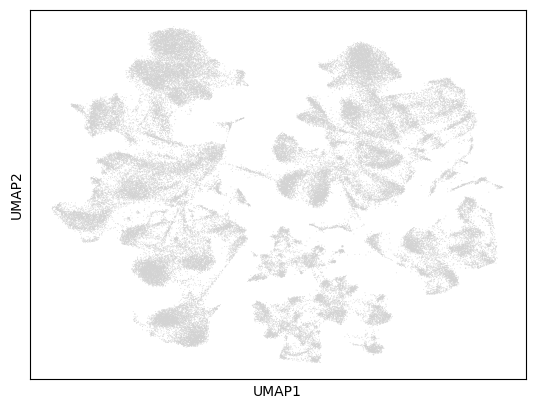

In [18]:
# Standard scanpy analysis 

sc.pp.normalize_total(Original_counts)
sc.pp.log1p(Original_counts)

sc.tl.pca(Original_counts)
sc.pp.neighbors(Original_counts)
sc.tl.umap(Original_counts)
sc.pl.umap(Original_counts)


In [19]:
# save the data 
Original_counts.write_h5ad(scdatapath+'Original_counts.h5ad')

### Find shared genes 
Now find the shared genes between two modalities and subset the matrix to retain only common genes. 

In [20]:
sp_genename=ad_spatial_ori.var_names.to_numpy()
sc_genename=ad_seq_ori.var_names.to_numpy()

index_sp,index_sc=sann.find_index(sp_genename,sc_genename)
#ad_seq_common=ad_seq_ori[:,index_sc].copy()
ad_seq_common=ad_seq_ori.copy()
ad_spatial_common=ad_spatial_ori[:,index_sp].copy()

print(len(sp_genename[index_sp]))
print(len(sc_genename[index_sc]))

335
335


### Perform scTransform like normalization with two different alternative stratgies

In [21]:
# The sctransform normalization function used from scanpy 


ad_seq_common.raw=ad_seq_common.copy()
ad_spatial_common.raw=ad_spatial_common.copy()
# perform scTranform normalization common gene space for spatial data and scRNAseq data  
sc.experimental.pp.normalize_pearson_residuals(ad_seq_common,inplace=True) #ad_seq_common.X[ad_seq_common.X<0]=0

ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')
sc.experimental.pp.normalize_pearson_residuals(ad_spatial_common,inplace=True) #ad_spatial_common.X[ad_spatial_common.X<0]=0
#print(ad_spatial_common.X.toarray()


# Perform Leiden clustering on spatial transcriptomics data to guide the NiCo annotations 

In [22]:
# standard scanpy analysis 
sc.pp.pca(ad_spatial_common)
sc.pp.neighbors(ad_spatial_common,n_pcs=30)
sc.tl.umap(ad_spatial_common)

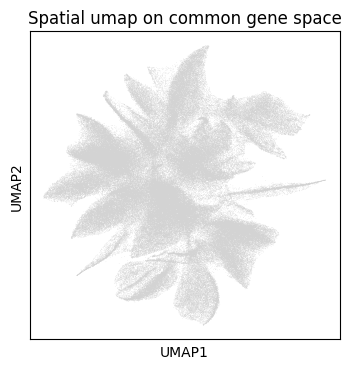

In [23]:
# visualize umap 
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_spatial_common, title=["Spatial umap on common gene space"],wspace=0.4,show=True)

### Guiding Leiden cluster resolutions
Peform Leiden clustering for several resolution parameters. 
If it takes a long time to compute, then you can limit the number of parameters. 

Any of the resolution parameters  here can be used as an input parameter (guiding_spatial_cluster_resolution_tag) in the NiCo pipeline

In [24]:
#sc.tl.leiden(ad_spatial_common, resolution=0.3,key_added="leiden0.3")
sc.tl.leiden(ad_spatial_common, resolution=0.4,key_added="leiden0.4")
sc.tl.leiden(ad_spatial_common, resolution=0.5,key_added="leiden0.5")
#sc.tl.leiden(sct_ad_sp, resolution=0.6,key_added="leiden0.6")
#sc.tl.leiden(sct_ad_sp, resolution=0.7,key_added="leiden0.7")
#sc.tl.leiden(sct_ad_sp, resolution=0.8,key_added="leiden0.8")

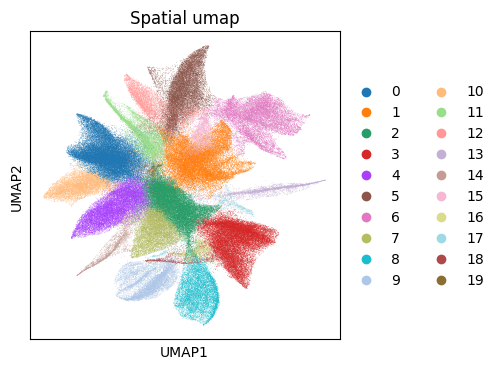

In [25]:
# Visualize your initial spatial clustering in the UMAP
# A good resolution parameter should yield clusters corresponding to major cell types.  

sc.pl.umap(ad_spatial_common, color=["leiden0.5"], title=["Spatial umap"],wspace=0.4,
           show=True, save='_spatial_umap.png')

In [26]:
# Save the Leiden clusters for all resolution parameters as well as normalized count data in h5ad format. 
ad_spatial_common.write_h5ad(spdatapath+'sct_spatial.h5ad')